In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from math import pi
import os, scipy, glob, time
from collections import defaultdict
from numpy.linalg import inv,det
from scipy import signal
from scipy import fftpack, fft
from scipy.fftpack import fftshift, irfft, rfft 
from scipy.signal import blackman
from scipy.stats import multivariate_normal

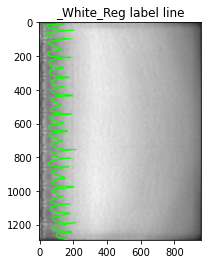

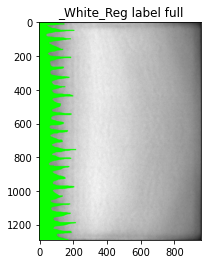

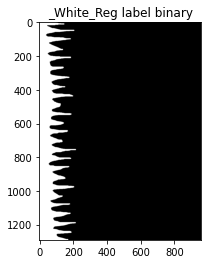

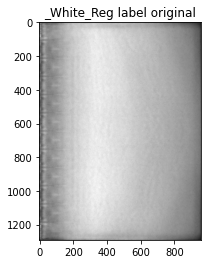

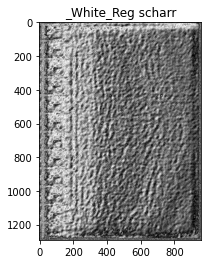

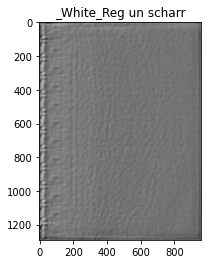

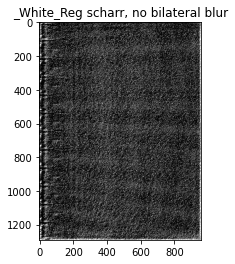

In [49]:
path = '/Users/estepark/Documents/week6_fri/Images'
results = '/Users/estepark/Documents/week6_fri/results'
annotations = '/Users/estepark/Documents/week11_mon/Vermouth_HVT/2018-09-10 D HVT HG8A/20180910/Data/HiResMesh/label'
originals = '/Users/estepark/Documents/week11_mon/Vermouth_HVT/2018-09-10 D HVT HG8A/20180910/Data/HiResMesh/results'

"""
all images in annotations path are the labelled ground truth imgs from paint program
must binarize the labelled ground truth image to make all white pixels == FG (foreground)
and all black pixels== BG (background)
"""
kern = [[0, 1,  0], [1, 0, -1],[ 0, -1 ,0]]
for fname in glob.glob(annotations+'/*.png'):
    serNum = fname.split('/')[-1][:-4] 
    
    annotation  = cv.imread(fname) # green line annotated label
    annotation_full = np.copy(annotation)
    annotation_binary = np.zeros(annotation.shape[:2])
    
    for i in range(annotation.shape[0]): 
        for j in range(annotation.shape[1])[::-1]:
            if annotation[i][j][0] == annotation[i][j][1] == annotation[i][j][2]:
                continue
            else:
                annotation_full[i][0:j][:] = annotation_full[i][j][:]
                annotation_binary[i][0:j] = 1
                break
    
    original = cv.imread(originals+'/{}.png'.format(serNum), cv.IMREAD_GRAYSCALE) # original label without annotation
    imgFilt = cv.bilateralFilter(original, 15, 75, 75)
    diag_img = signal.convolve2d(imgFilt, np.array(kern), boundary='symm', mode='same') # scharr filter 
    scharr = (((diag_img+2))/4*255).astype(np.uint8) #normalize after scharr, bc min=-2 and max=+2
    
    diag_img_test = signal.convolve2d(original, np.array(kern), boundary='symm', mode='same') # scharr filter 
    scharr_test = (((diag_img_test+2))/4).astype(np.uint8) #normalize after scharr, bc min=-2 and max=+2
    
    original = (original-np.min(original))/(np.max(original) - np.min(original)) # normalize label [0,1]

    plt.figure()
    plt.title(serNum+' label line')
    plt.imshow(annotation)
    plt.show()
    
    plt.figure()
    plt.title(serNum+' label full')
    plt.imshow(annotation_full)
    plt.show()
    
    plt.figure()
    plt.title(serNum+' label binary')
    plt.imshow(annotation_binary, cmap="gray")
    plt.show()
    
    plt.figure()
    plt.title(serNum+' label original')
    plt.imshow(original, cmap="gray")
    plt.show()
    
    plt.figure()
    plt.title(serNum+' scharr')
    plt.imshow(scharr, cmap="gray")
    plt.show()
    
    plt.figure()
    plt.title(serNum+' un scharr')
    plt.imshow(diag_img, cmap="gray")
    plt.show()
    
    plt.figure()
    plt.title(serNum+' scharr, no bilateral blur')
    plt.imshow(scharr_test, cmap="gray")
    plt.show()

In [50]:
import scipy.fftpack

""""""
def dct2d(a):
    """
    **parameters: 
        8x8 patches of the image to do a 1D dct (numpy array)
    **output: 2D dct
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html
        dct from scipy can only do 1 dim, so here to make it a 2dim, first run on 1 dim then next
        so thats why is axis=0 (horizontal), then axis=1 (veritcal)
    """
    return scipy.fftpack.dct(scipy.fftpack.dct( a, axis=0, norm='ortho' ),axis=1,norm='ortho')
n = 0

ch_dct = []
not_dct = []
bad_ch = 0
bad_not = 0 

"""
input: for every column correponding, apply sliding window to image to every row
output: create sliding window to take 0->8, then 1->9, then 2->10 of the label
"""
for i in range(original.shape[0]-7): 
    for j in range(original.shape[1]-7): 
        patch = original[i:i+8, j:j+8] # this is the oringal Lv image matrix
        scharr_patch = scharr[i:i+8,j:j+8]
        """
        flatten the 8x8 return matrix of dct2 of dct coefficients
        """
        vec = dct2d(patch).flatten()
        #print(i,',',j,':',vec)
        """
        checking if 1st value in patch2 is same as the rest for uniformity
        if it is uniform, then leave out in the calc of mean and cov
            by appending into bad_ch
            can think of dct has output scores of uniformity
            if has same color/textures, then it's uniform and can be left off
        if include uniform patches, then return value of dct2d, will be huge value for 1st and skews the rest
        """
        if np.all(scharr_patch == scharr_patch[0][0]): 
            #print(i,',',j,':',vec)
            if annotation_binary[i,j] == 1: 
                """
                bad_ch can very well be a ch pixel, but its a uniform ch so we ignore it
                bad_not is not ch
                """
                bad_ch += 1
            else: 
                bad_not += 1 
            continue
        if annotation_binary[i,j] == 1: 
            ch_dct.append(vec)
        else: 
            not_dct.append(vec)
        assert patch.shape == (8,8)
        n = n + 1
print(n)
#print(label.shape[0]*label.shape[1])
print('bad ch = {}, bad not = {}'.format(bad_ch, bad_not))


1224671
bad ch = 0, bad not = 265


In [51]:
"""
check the number of rows, you'll have an nx64 bags of ch_dct == all 8x8 patches in FG
then the other mx64 bags of not_dct which correspond to all patches in BG
"""
ch_dct = np.array(ch_dct)
not_dct = np.array(not_dct)
print(ch_dct.shape)
print(not_dct.shape)

(143411, 64)
(1081260, 64)


In [52]:
np.mean(ch_dct, axis=0)

array([ 4.41223611e+00, -2.87901869e-02, -8.75048369e-04, -3.60154080e-03,
       -2.71350914e-04, -1.10720272e-03, -1.03947999e-04, -2.78231901e-04,
        4.90806150e-03,  2.50681972e-04, -4.09258170e-06,  2.33107101e-05,
       -3.13679977e-06,  3.59023946e-06,  4.52800013e-07, -1.10841315e-07,
       -1.14532136e-04,  2.46777168e-05,  8.86934695e-07,  5.02357732e-07,
       -1.32941171e-07, -2.70919576e-06,  4.38241028e-07,  9.47490405e-07,
        4.55819115e-04,  1.39970758e-05, -6.73349040e-06,  2.54366821e-06,
       -1.33614974e-06,  5.18624933e-07,  1.09467969e-06,  6.14379889e-07,
       -8.10162920e-05,  6.27385401e-06, -3.52051998e-06,  9.88429411e-07,
       -7.24641545e-07, -7.33916208e-07,  9.32883054e-07,  3.32010124e-07,
        1.34099488e-04, -1.68098344e-06, -6.53530825e-07,  6.66308455e-07,
        1.59290830e-06, -4.12785101e-07,  4.77637652e-07,  6.24338255e-08,
       -4.92040263e-05, -2.02098618e-06, -1.92709836e-06,  2.94031245e-07,
       -8.03275260e-07,  

In [53]:
np.mean(not_dct, axis=0)

array([ 5.86073837e+00,  5.94977802e-03, -4.03185685e-04,  6.75292015e-04,
       -1.11058703e-04,  2.11168453e-04, -3.87347383e-05,  5.42191927e-05,
        1.09895238e-03, -3.21670951e-05,  4.23507076e-07, -2.85560467e-06,
        3.06922034e-07, -2.99143185e-07,  1.29985325e-07, -1.10906870e-07,
       -3.35105416e-04, -6.22317160e-06, -1.56166769e-07, -1.36750019e-07,
        1.19315629e-07,  3.25695755e-07, -2.04747205e-07, -1.51487050e-07,
        7.32758961e-05, -1.44196402e-06,  1.21506190e-06,  5.80867246e-08,
        1.54352702e-07, -9.60869049e-08, -2.75730806e-07, -3.95023518e-09,
       -1.36428524e-04, -1.82371760e-06,  4.90479273e-07, -5.82456059e-08,
        9.88316826e-08,  6.46025814e-08,  2.55073988e-08,  5.05452260e-08,
        5.86941740e-06,  3.02773888e-07,  1.83282251e-07, -6.00319266e-08,
       -1.07908667e-07,  1.12657842e-08, -5.91885374e-08,  2.27601246e-08,
       -5.25783156e-05,  6.17063906e-08,  4.00936868e-07, -1.04579662e-07,
        7.71808654e-08, -

In [54]:
foreground = ch_dct
background = not_dct
print(ch_dct.shape[1] )
print(ch_dct.shape[0])
total = ch_dct.shape[0] + not_dct.shape[0]
print(total==n)

# suspected that valid ch has lower probability considering 
# it takes less area of the total image
# P_Y=y
prior_ch = ch_dct.shape[0]/ total
# P_X=x
prior_chNot = not_dct.shape[0]/ total
print("Probability RV Y=valid ch: {}".format(prior_ch))
print("Probability RV X=invalid ch: {}".format(prior_chNot))

64
143411
True
Probability RV Y=valid ch: 0.11710165424020003
Probability RV X=invalid ch: 0.8828983457598


In [55]:
#MLE for background
mean_BG = np.mean(background,axis = 0)
var_BG = np.var(background,axis = 0)
se_BG = np.sqrt(var_BG)
# background trasnpose, it needs to be transposed to correctly compute the convariance
#cov needs to be 64x64 matrix, how much ea dim varies wrt ever otehr dim, so diag will be the var of ea dim
# can think of cov as how 1 rv varies with the other
cov_BG = np.cov(background.T)

In [56]:
#MLE for foreground
N = foreground.shape[0] # nubmer of rows in valid ch mat 
base_FG = np.zeros(foreground.shape[1]) + (-N/2 * np.log(2 * np.pi))
mean_FG = np.mean(foreground,axis = 0)
var_FG = np.var(foreground,axis = 0)
se_FG = np.sqrt(var_FG)
cov_FG = np.cov(foreground.T)

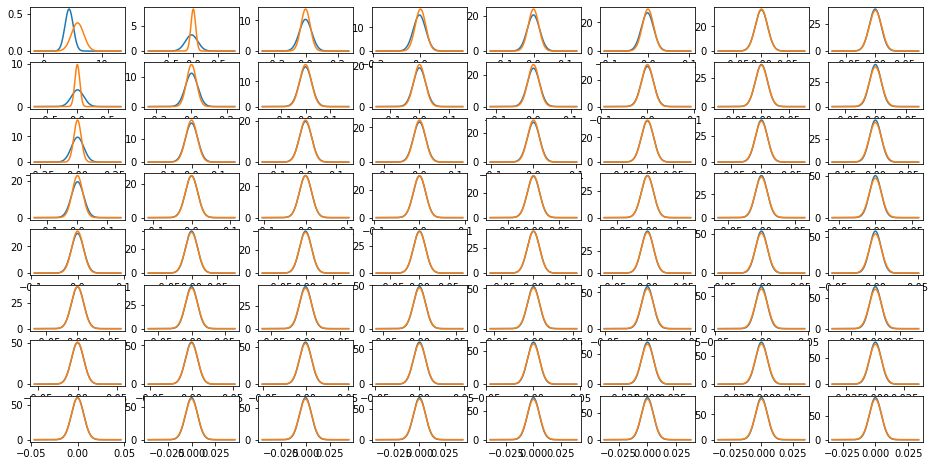

In [57]:
#marginal density plot of the means of ea mx64 patches in BG, nx64 ch_dct patches in FG
from scipy.stats import norm
from scipy.special import kl_div
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(16,8))
KL_distance = []

#with the labelled img, plotting prob density fn of all indecies of dct starting at 0 index
# where blue is FG and orange is BG
for i in range(foreground.shape[1]):
    fig.add_subplot(8,8,i+1)
    x_FG = np.linspace(mean_FG[i] - 7 * se_FG[i] ,mean_FG[i] + 7 * se_FG[i],500)
    x_BG = np.linspace(mean_BG[i] - 7 * se_BG[i], mean_BG[i] + 7 * se_BG[i],500)
    
    x = np.sort(np.array([x_FG,x_BG]),axis = None)
    
    y_FG = norm.pdf(x,mean_FG[i],se_FG[i])
    y_BG = norm.pdf(x,mean_BG[i],se_BG[i])
    
    plt.plot(x,y_FG,x,y_BG)
#     title = "Fit result for the %d feature" %(i+1)
#     plt.title(title)
plt.show()

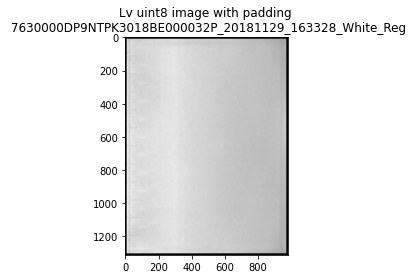

7630000DP9NTPK3018BE000032P_20181129_163328_White_Reg is in the shape of RECTANGLE


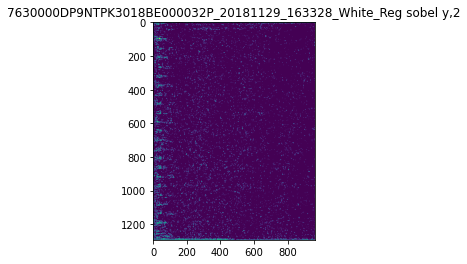

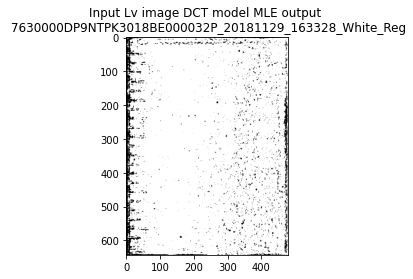

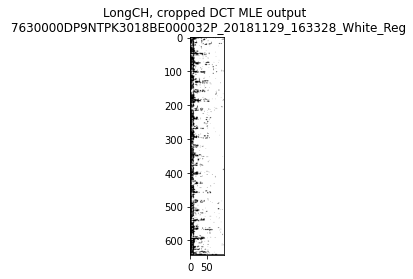

number of white pxiels: 10337


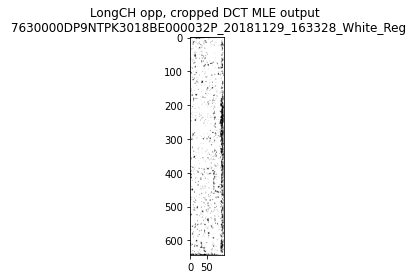

number of white pxiels: 5485


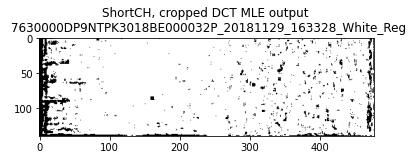

number of white pxiels: 5193


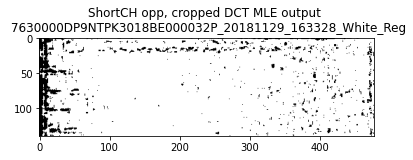

number of white pxiels: 5016
Input is LONG Crosshatch
score is 3711180.2722761747


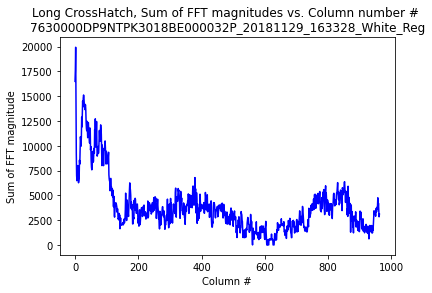

L
Long CH score: 3711180.2722761747
total seconds to classify input: 592.9996838569641


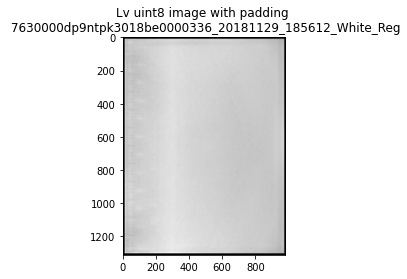

7630000dp9ntpk3018be0000336_20181129_185612_White_Reg is in the shape of RECTANGLE


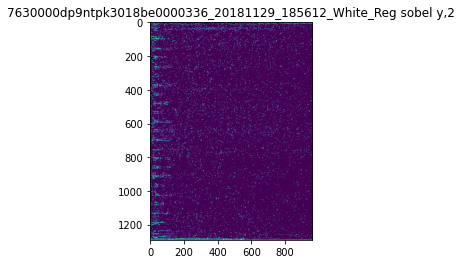

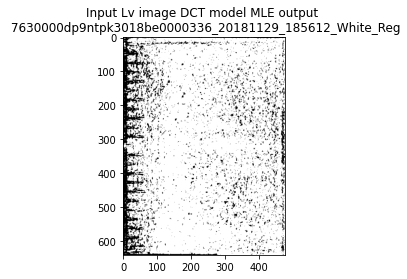

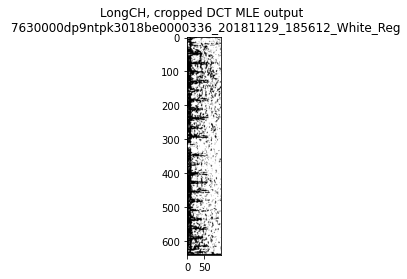

number of white pxiels: 22433


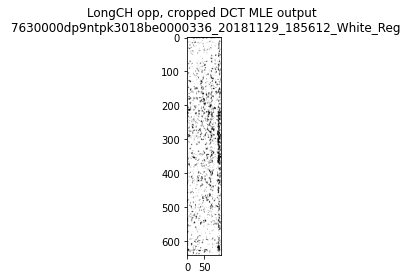

number of white pxiels: 7505


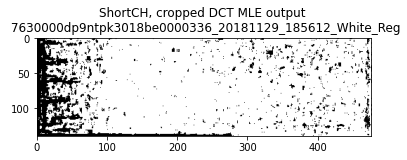

number of white pxiels: 8285


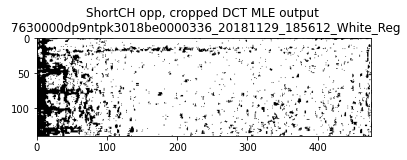

number of white pxiels: 9228
Input is LONG Crosshatch
score is 5021650.6325568305


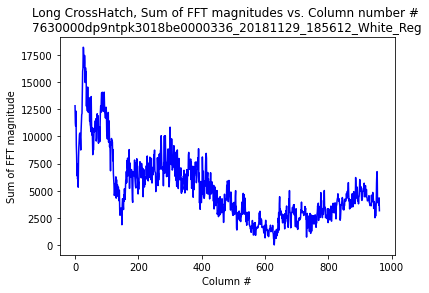

L
Long CH score: 5021650.6325568305
total seconds to classify input: 610.914155960083


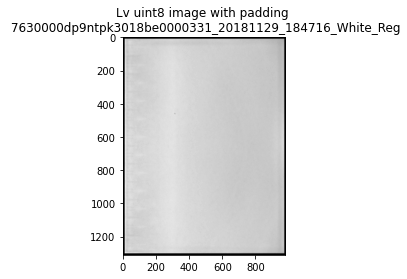

7630000dp9ntpk3018be0000331_20181129_184716_White_Reg is in the shape of RECTANGLE


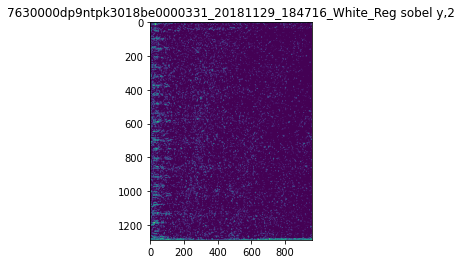

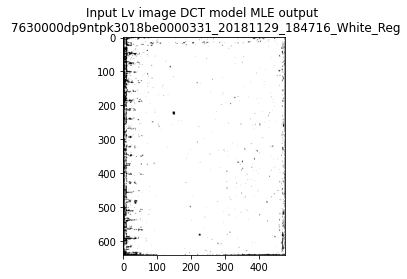

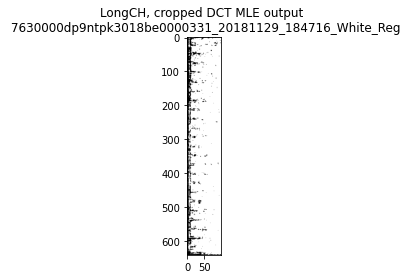

number of white pxiels: 8164


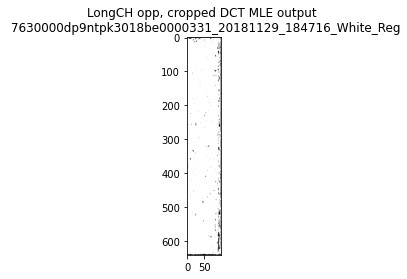

number of white pxiels: 1896


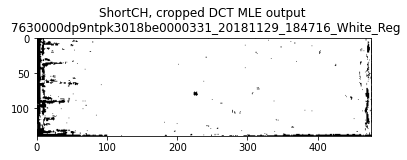

number of white pxiels: 2998


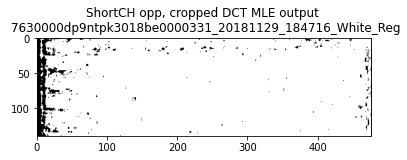

number of white pxiels: 3342
Input is LONG Crosshatch
score is 4561929.380483727


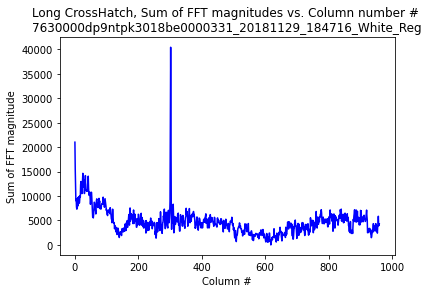

L
Long CH score: 4561929.380483727
total seconds to classify input: 603.1610851287842


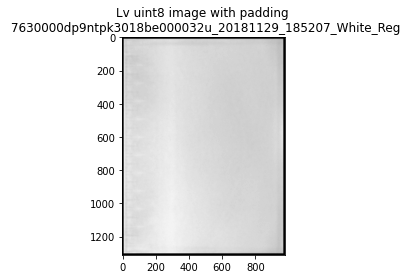

7630000dp9ntpk3018be000032u_20181129_185207_White_Reg is in the shape of RECTANGLE


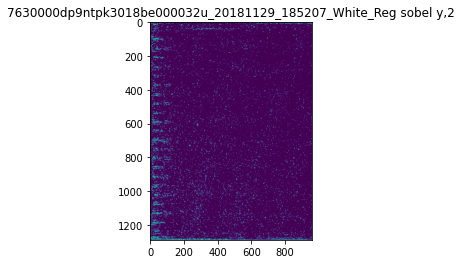

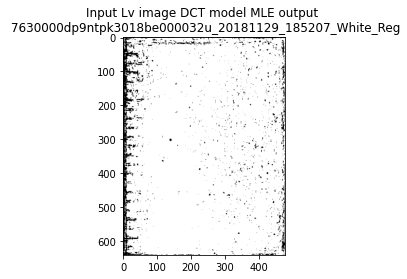

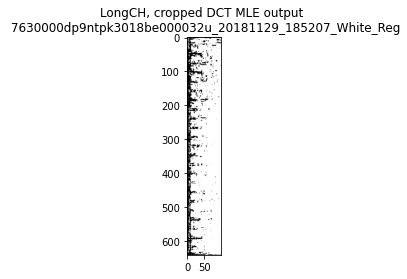

number of white pxiels: 11423


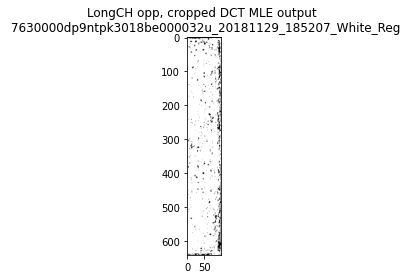

number of white pxiels: 4167


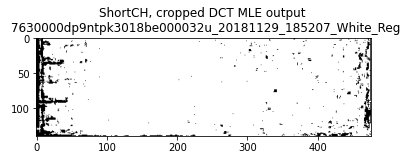

number of white pxiels: 3693


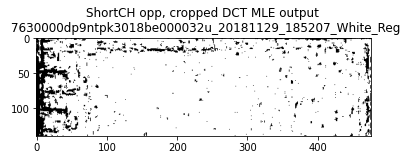

number of white pxiels: 6461
Input is LONG Crosshatch
score is 4666480.564139748


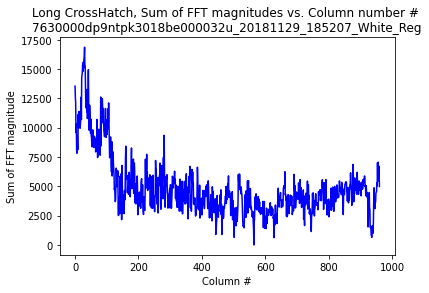

L
Long CH score: 4666480.564139748
total seconds to classify input: 612.0776410102844


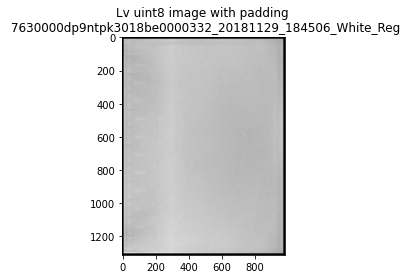

7630000dp9ntpk3018be0000332_20181129_184506_White_Reg is in the shape of RECTANGLE


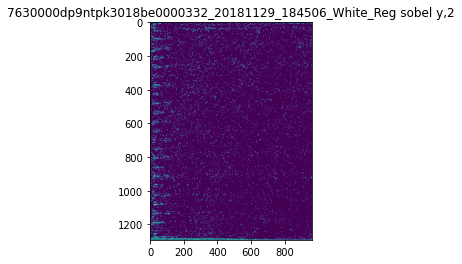

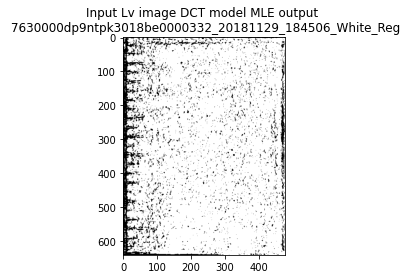

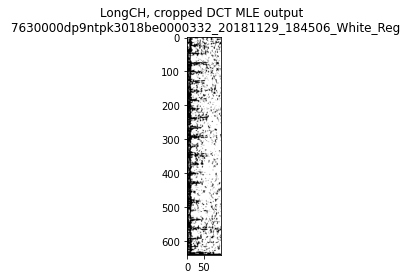

number of white pxiels: 18289


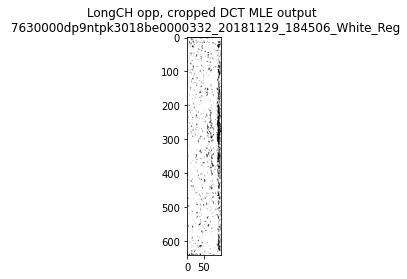

number of white pxiels: 5725


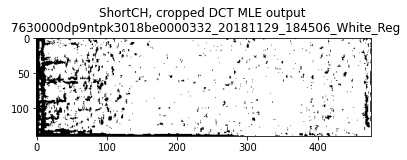

number of white pxiels: 6876


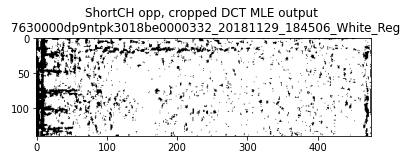

number of white pxiels: 8656
Input is LONG Crosshatch
score is 5255843.960391094


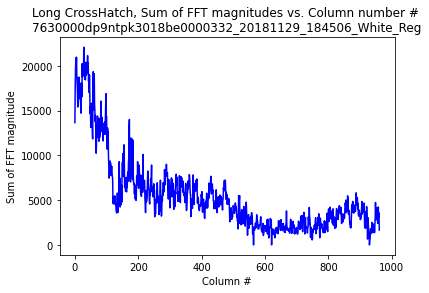

L
Long CH score: 5255843.960391094
total seconds to classify input: 615.6426990032196


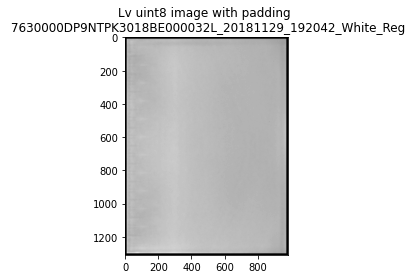

7630000DP9NTPK3018BE000032L_20181129_192042_White_Reg is in the shape of RECTANGLE


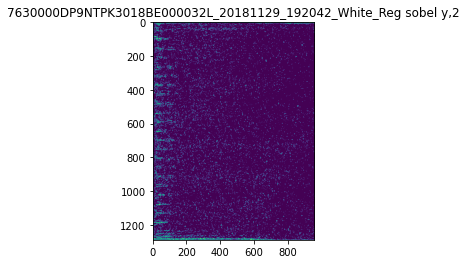

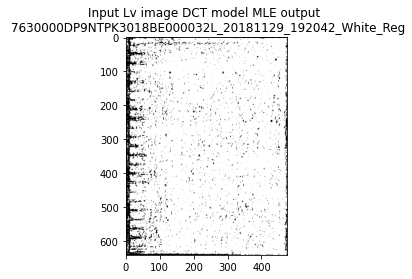

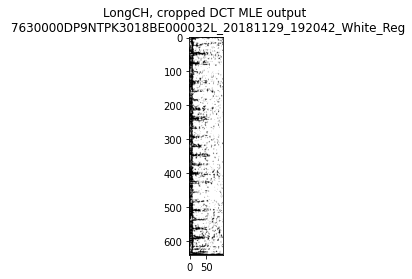

number of white pxiels: 14468


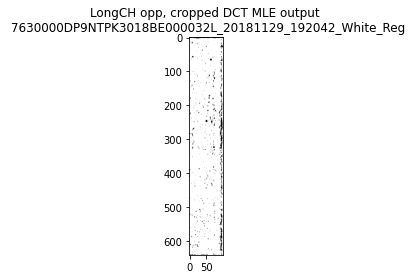

number of white pxiels: 2907


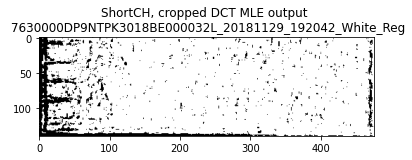

number of white pxiels: 6401


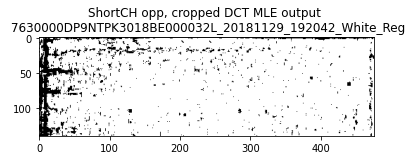

number of white pxiels: 5603
Input is LONG Crosshatch
score is 8376211.330419468


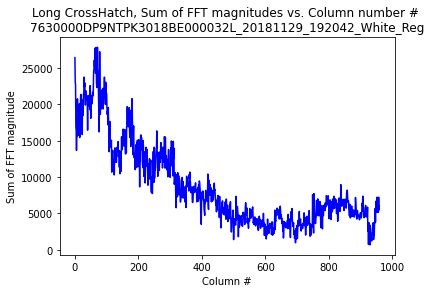

L
Long CH score: 8376211.330419468
total seconds to classify input: 613.7477159500122


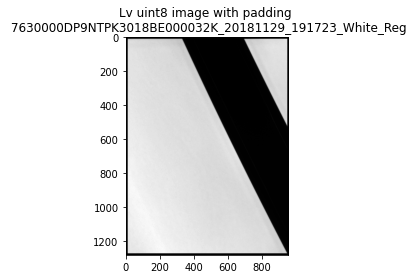

7630000DP9NTPK3018BE000032K_20181129_191723_White_Reg is in the shape of RECTANGLE


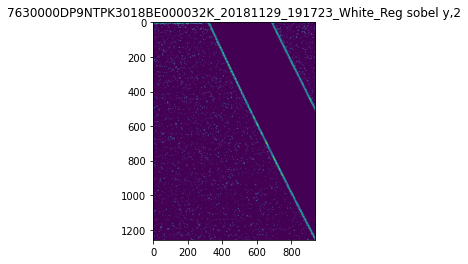

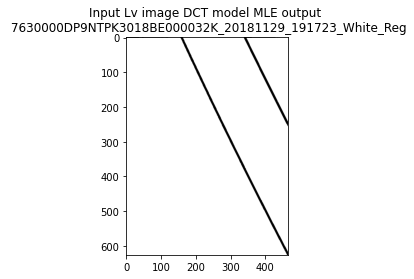

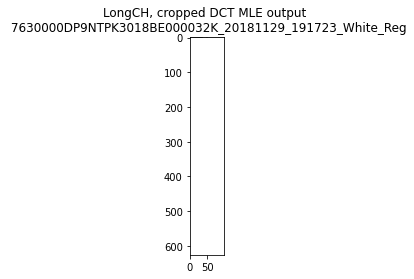

number of white pxiels: 139


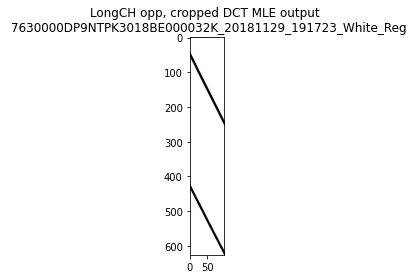

number of white pxiels: 2957


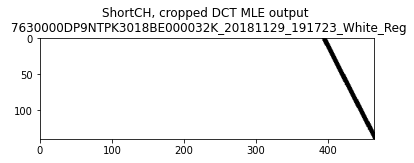

number of white pxiels: 982


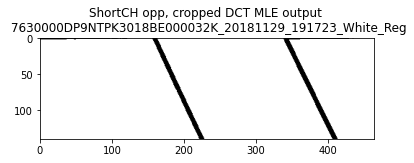

number of white pxiels: 2282
Input is SHORT Crosshatch
score is 60094674.25963268


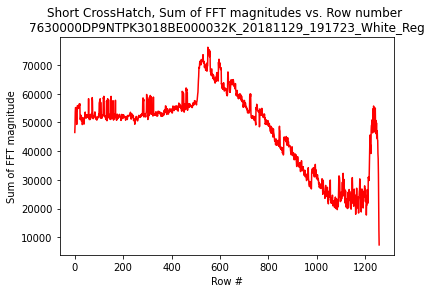

L
Short CH score: 8376211.330419468
total seconds to classify input: 577.6816079616547


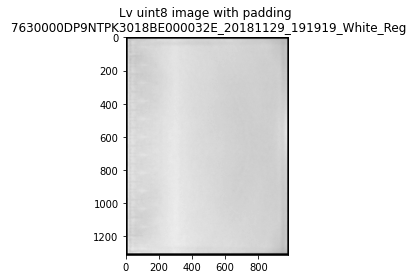

7630000DP9NTPK3018BE000032E_20181129_191919_White_Reg is in the shape of RECTANGLE


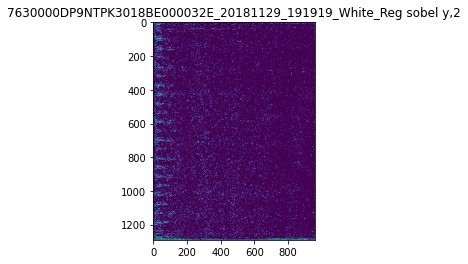

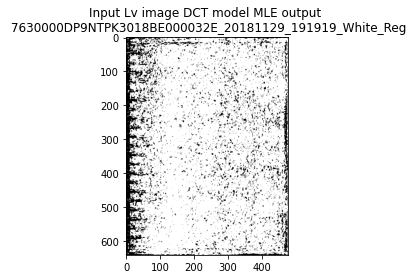

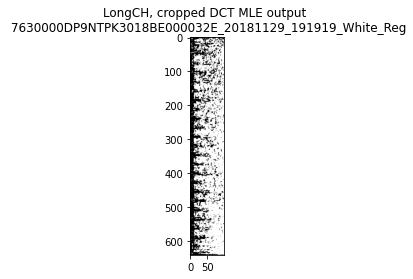

number of white pxiels: 21651


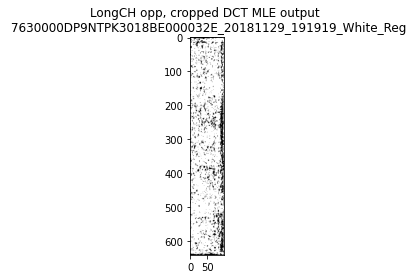

number of white pxiels: 9635


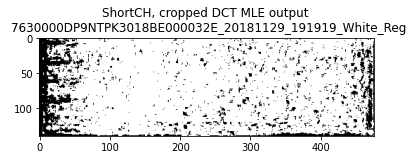

number of white pxiels: 9350


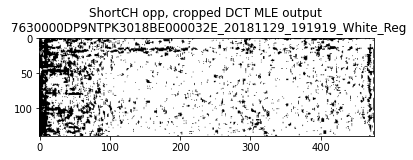

number of white pxiels: 11064
Input is LONG Crosshatch
score is 4054738.9159105713


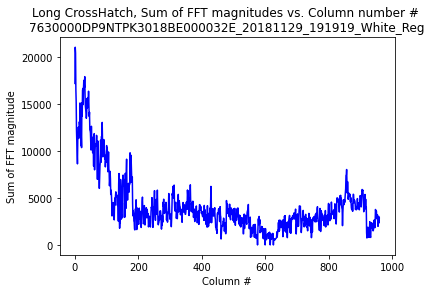

L
Long CH score: 4054738.9159105713
total seconds to classify input: 616.4240918159485


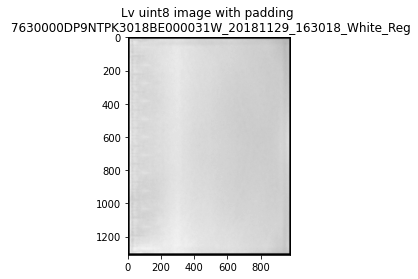

7630000DP9NTPK3018BE000031W_20181129_163018_White_Reg is in the shape of RECTANGLE


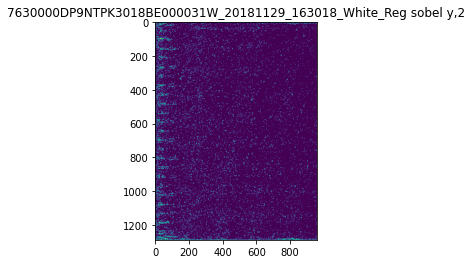

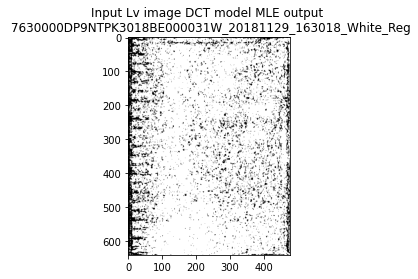

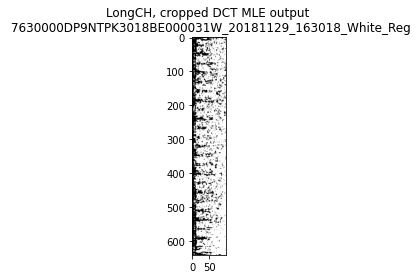

number of white pxiels: 17735


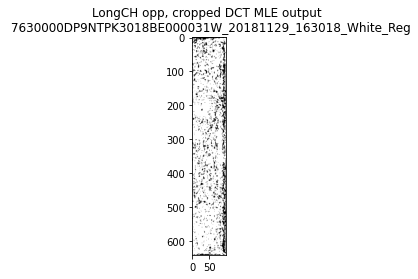

number of white pxiels: 9806


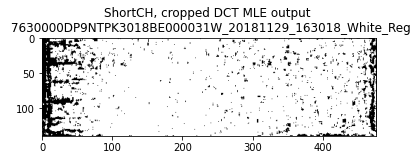

number of white pxiels: 6599


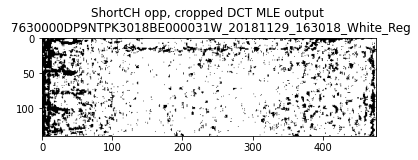

number of white pxiels: 10535
Input is LONG Crosshatch
score is 5428378.662953302


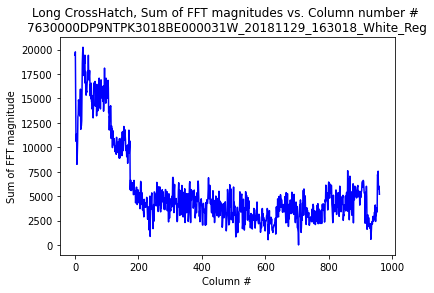

L
Long CH score: 5428378.662953302
total seconds to classify input: 604.4926331043243


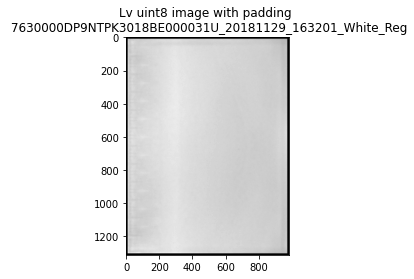

7630000DP9NTPK3018BE000031U_20181129_163201_White_Reg is in the shape of RECTANGLE


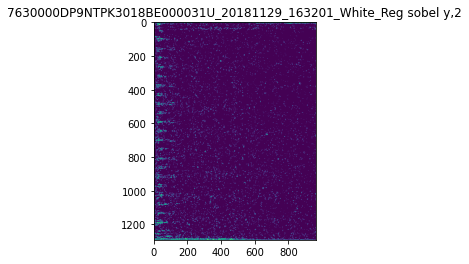

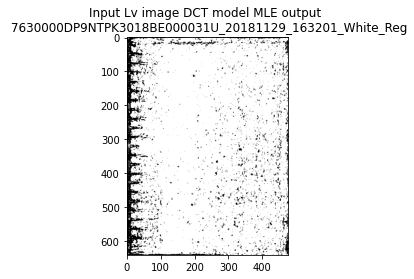

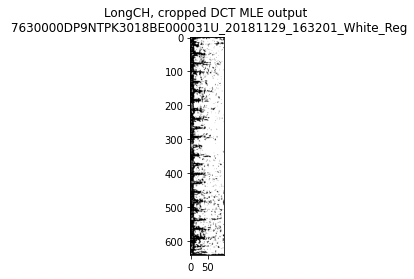

number of white pxiels: 16878


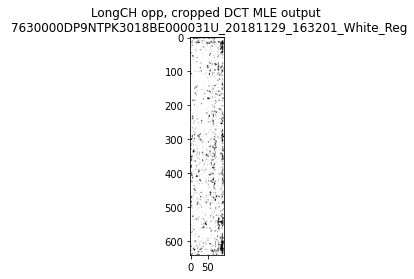

number of white pxiels: 5616


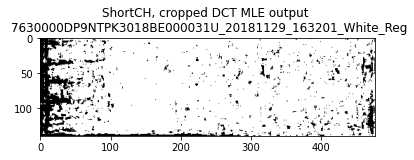

number of white pxiels: 7358


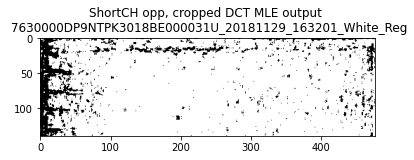

number of white pxiels: 7346
Input is LONG Crosshatch
score is 4084968.663881234


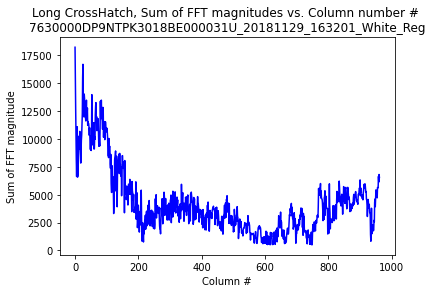

L
Long CH score: 4084968.663881234
total seconds to classify input: 610.3664860725403


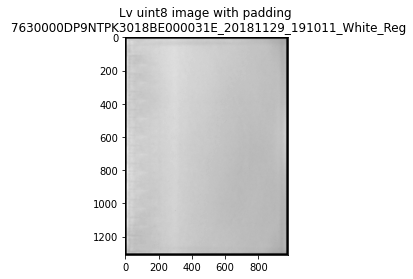

7630000DP9NTPK3018BE000031E_20181129_191011_White_Reg is in the shape of RECTANGLE


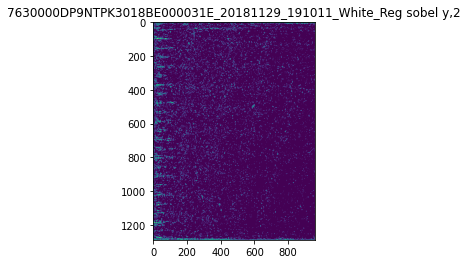

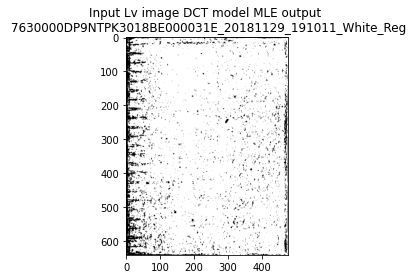

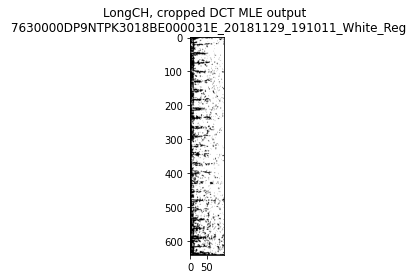

number of white pxiels: 14826


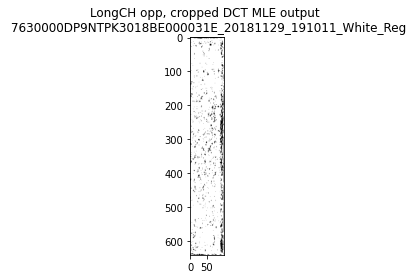

number of white pxiels: 4711


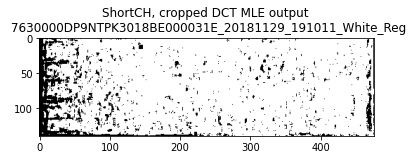

number of white pxiels: 7242


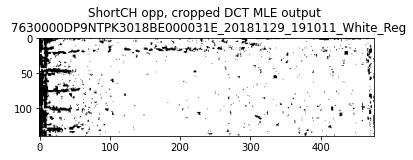

number of white pxiels: 5577
Input is LONG Crosshatch
score is 3696462.4610224236


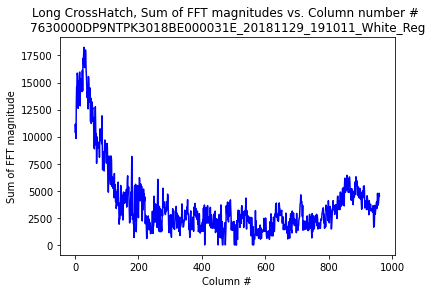

L
Long CH score: 3696462.4610224236
total seconds to classify input: 605.7153418064117


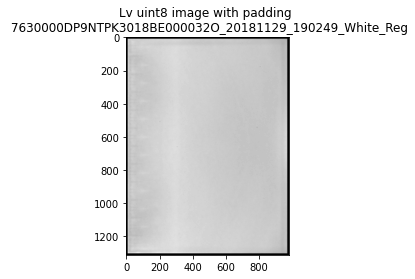

7630000DP9NTPK3018BE000032O_20181129_190249_White_Reg is in the shape of RECTANGLE


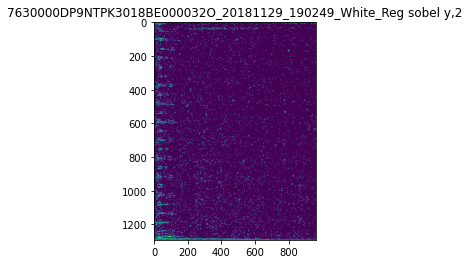

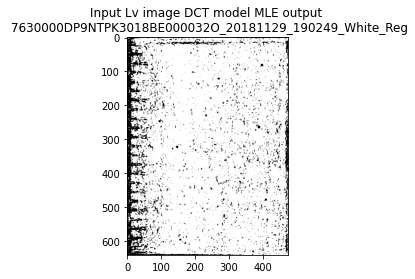

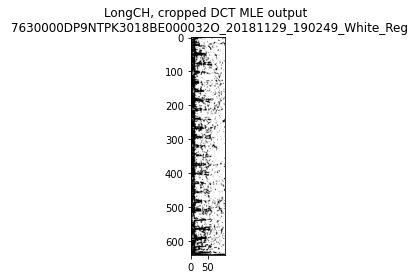

number of white pxiels: 19864


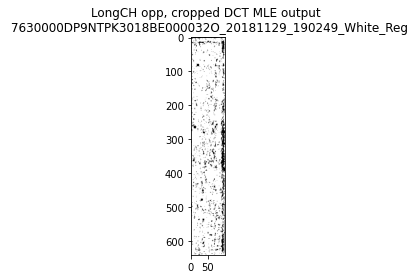

number of white pxiels: 6859


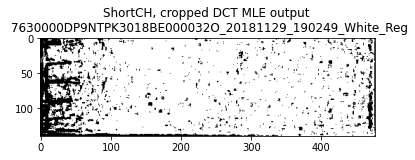

number of white pxiels: 8489


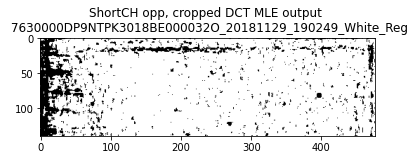

number of white pxiels: 8124
Input is LONG Crosshatch
score is 5585011.795441847


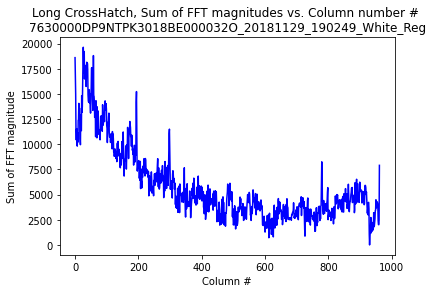

L
Long CH score: 5585011.795441847
total seconds to classify input: 605.3949999809265


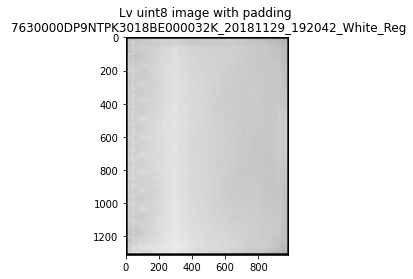

7630000DP9NTPK3018BE000032K_20181129_192042_White_Reg is in the shape of RECTANGLE


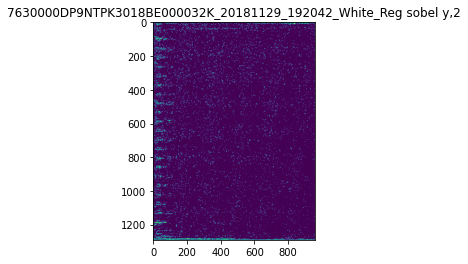

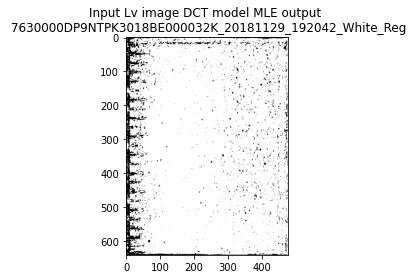

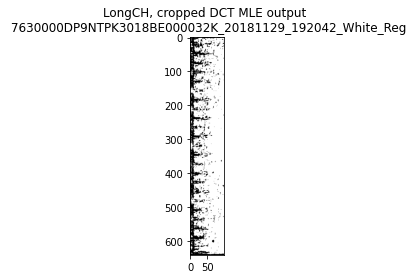

number of white pxiels: 14053


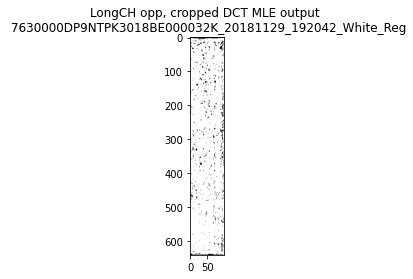

number of white pxiels: 3798


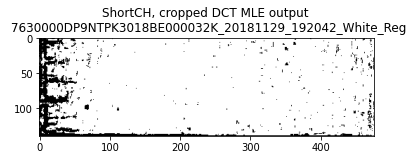

number of white pxiels: 5100


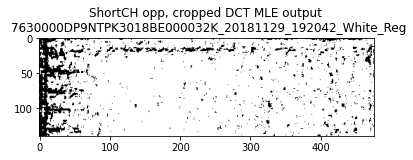

number of white pxiels: 7239
Input is LONG Crosshatch
score is 6666758.484306262


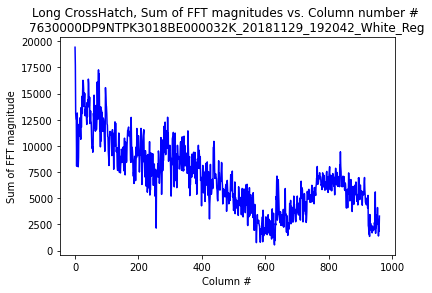

L
Long CH score: 6666758.484306262
total seconds to classify input: 595.8537878990173


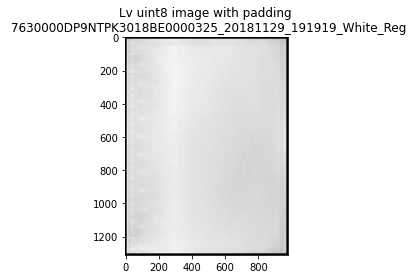

7630000DP9NTPK3018BE0000325_20181129_191919_White_Reg is in the shape of RECTANGLE


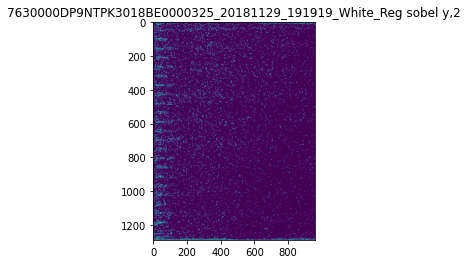

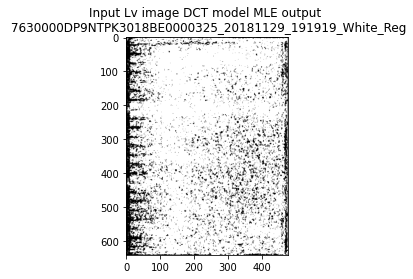

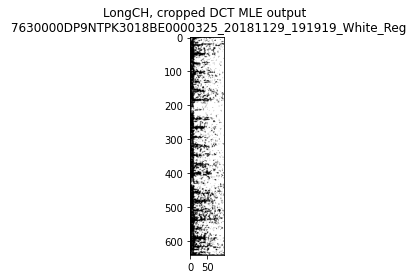

number of white pxiels: 20220


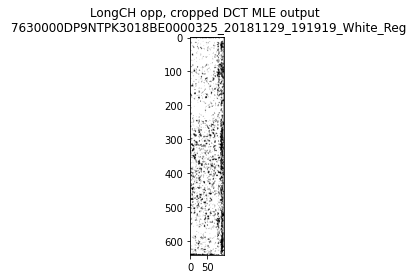

number of white pxiels: 10449


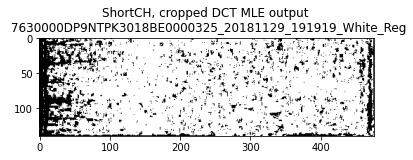

number of white pxiels: 11414


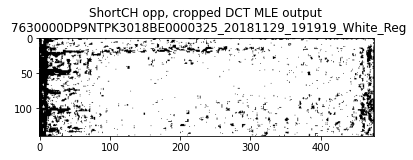

number of white pxiels: 8262
Input is LONG Crosshatch
score is 3518408.3326298706


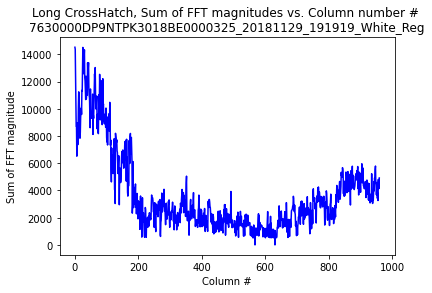

L
Long CH score: 3518408.3326298706
total seconds to classify input: 602.6961600780487


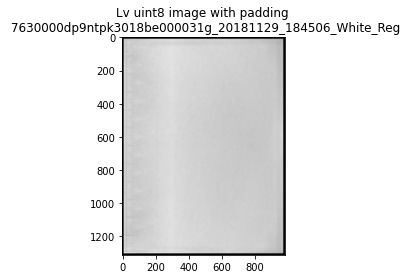

7630000dp9ntpk3018be000031g_20181129_184506_White_Reg is in the shape of RECTANGLE


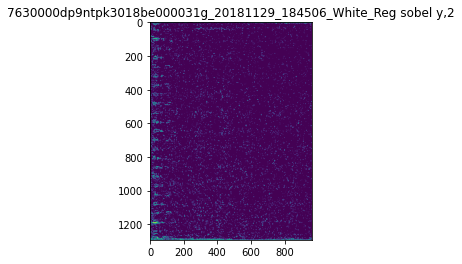

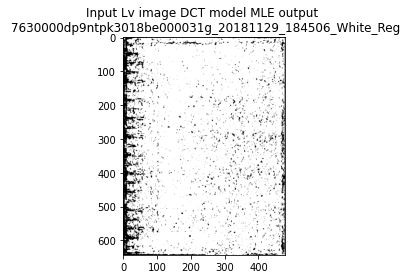

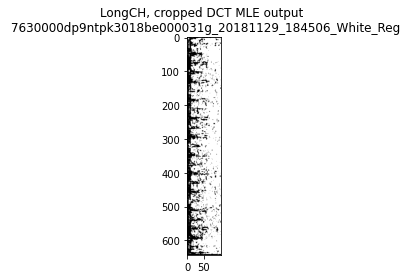

number of white pxiels: 16818


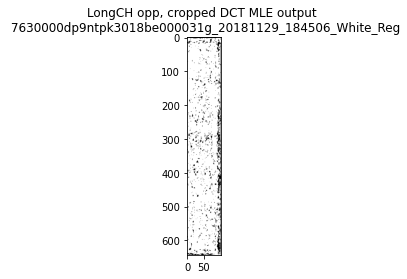

number of white pxiels: 5953


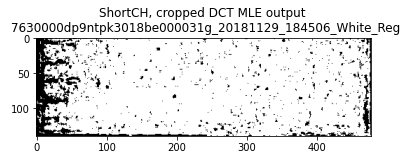

number of white pxiels: 7403


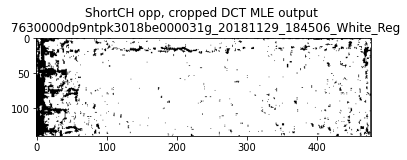

number of white pxiels: 6492
Input is LONG Crosshatch
score is 3677206.809232457


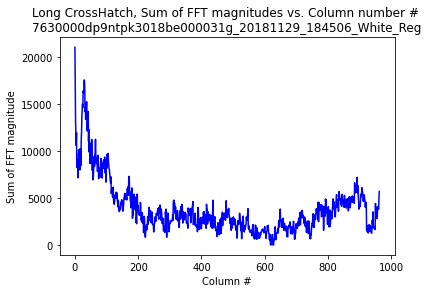

L
Long CH score: 3677206.809232457
total seconds to classify input: 599.7913160324097


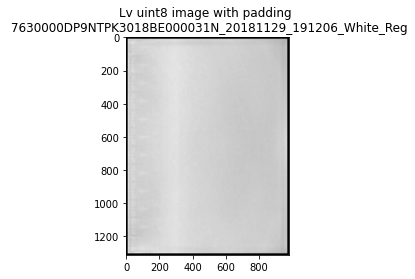

7630000DP9NTPK3018BE000031N_20181129_191206_White_Reg is in the shape of RECTANGLE


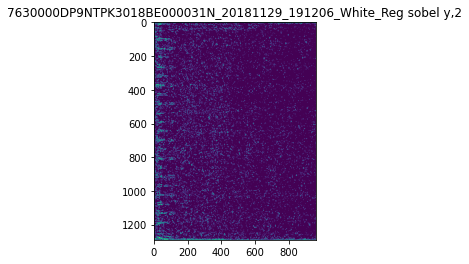

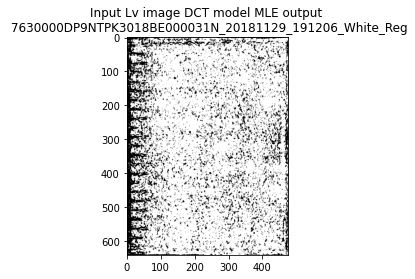

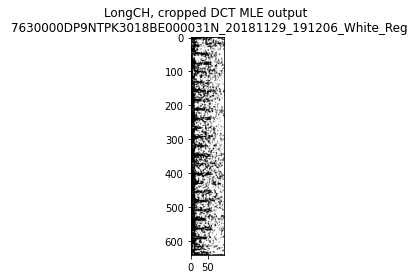

number of white pxiels: 26505


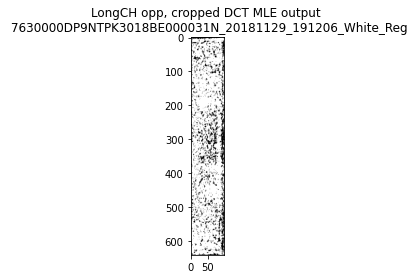

number of white pxiels: 11733


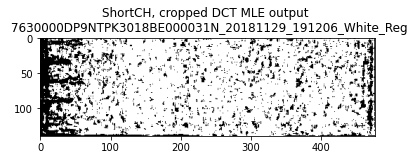

number of white pxiels: 12641


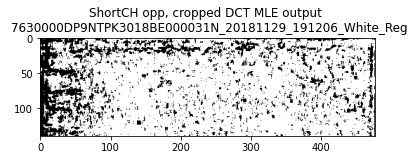

number of white pxiels: 13613
Input is LONG Crosshatch
score is 4088183.447546971


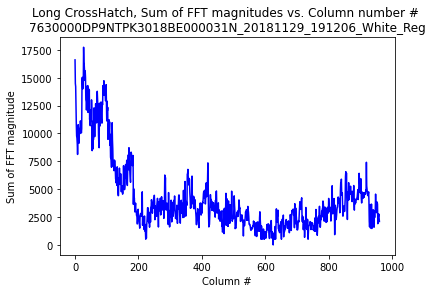

L
Long CH score: 4088183.447546971
total seconds to classify input: 667.9355871677399


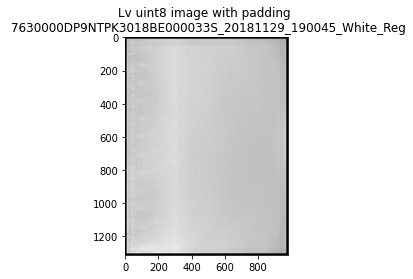

7630000DP9NTPK3018BE000033S_20181129_190045_White_Reg is in the shape of RECTANGLE


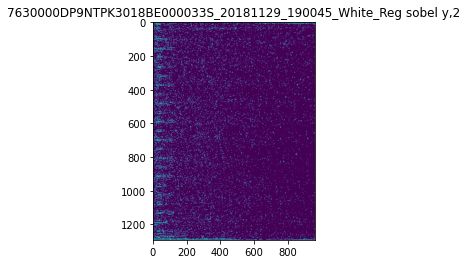

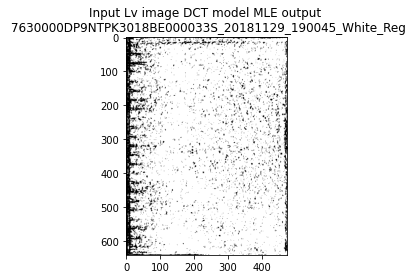

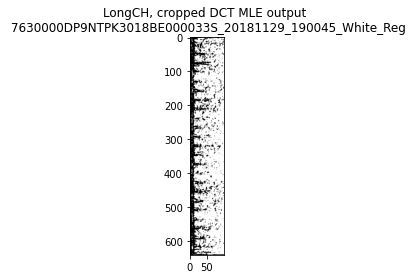

number of white pxiels: 17937


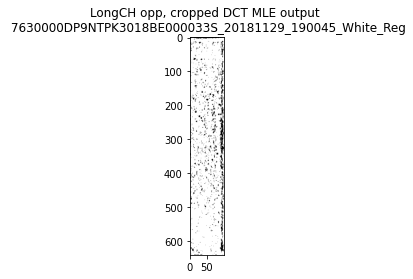

number of white pxiels: 5748


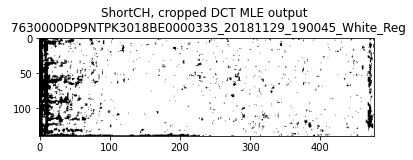

number of white pxiels: 5818


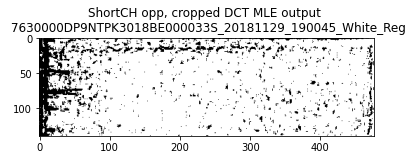

number of white pxiels: 8334
Input is LONG Crosshatch
score is 6194713.082139611


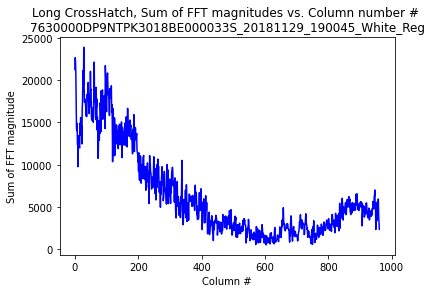

L
Long CH score: 6194713.082139611
total seconds to classify input: 623.7701330184937


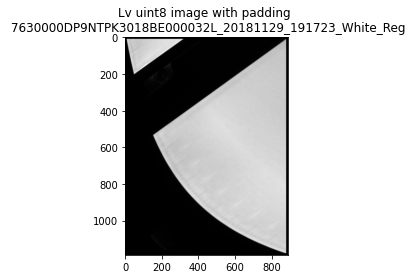

7630000DP9NTPK3018BE000032L_20181129_191723_White_Reg is in the shape of RECTANGLE


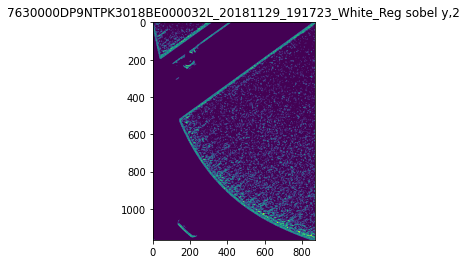

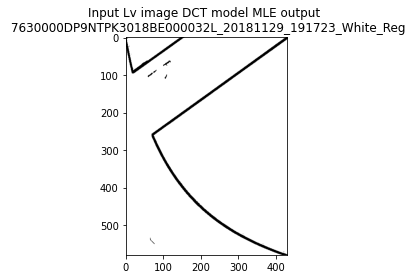

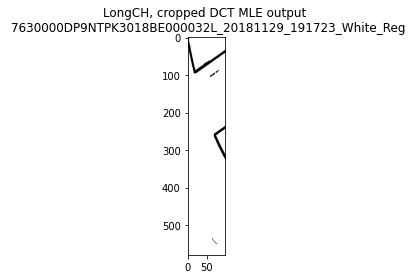

number of white pxiels: 1995


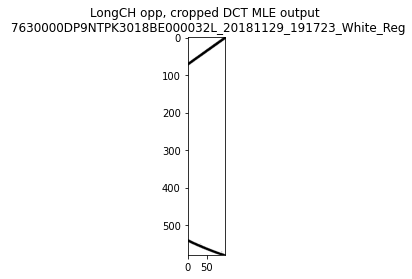

number of white pxiels: 1499


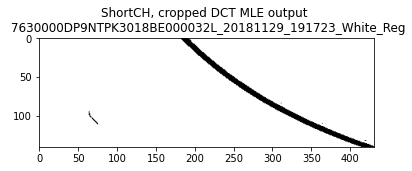

number of white pxiels: 1936


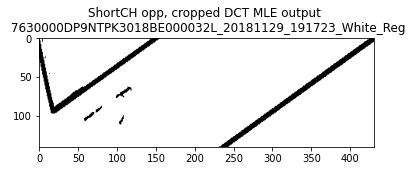

number of white pxiels: 3389
Input is LONG Crosshatch
score is 47159093.483614415


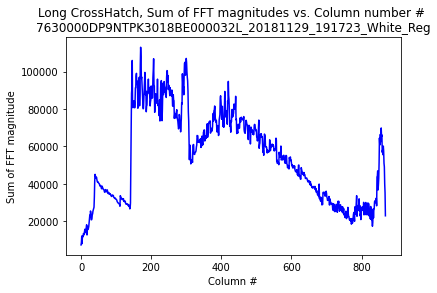

L
Long CH score: 47159093.483614415
total seconds to classify input: 470.47729110717773


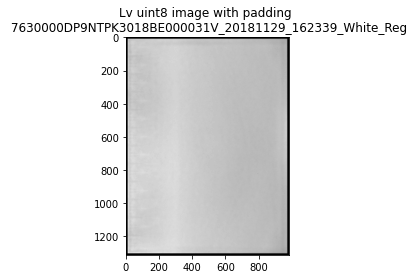

7630000DP9NTPK3018BE000031V_20181129_162339_White_Reg is in the shape of RECTANGLE


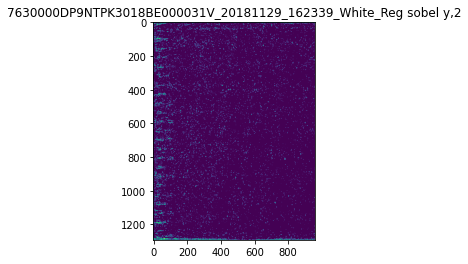

KeyboardInterrupt: 

In [60]:
class CrossHatch(object):
    #def __init__(self, path, geom ):
    """
    returns original Lv image, shape recognition geometry (circle or rect), cropped image of crosshatch, score
    **parameters: 
        path (str): the name of the directory where all the csv and/or text files are located
    **returns:
        Lv image (numpy array): the original greyscaled tristimulus y luminance image from csv or text Lv matrix
        shape geometry (str): after padding the image with 0's (black), binarize img, count contour verticies
        DCT based Bayesian MLE img (numpy array): binarzed white & black image of ground truth data vs. input
        cropped imgs (numpy array): 1 of 4 cross sections will be returned to distinguish long against short
    """
    def __init__(self, path ):
        assert os.path.isdir(pathTest), "hey haayyyyyy, path is invalid"
        self.path = path
        self.crossHatchery = {}
        widthP = 10
        tupCount = 0 
        for fname in (glob.glob(self.path+'/*.csv')) :
            start = time.time()
            Lv_csv = pd.read_csv(fname, skiprows=[0], header=None)
            # assumption: the Lv matrix will exceed no greater than 1500 #of rows
            for i in range(0,1500):
                # find element's index corresponding to u'
                if ( Lv_csv[0][i] =="u'" ): 
                    # save all Lv matrix values until u' index
                    Lvindex = int(np.where(Lv_csv == Lv_csv[0][i])[0] ) 
                    break     # as soon as matched index valid, exit & search no further
            # concatenated Lv matrix that excludes u' and v' matrix in csv file
            Lv = np.array(Lv_csv[0: Lvindex], dtype="float32" ) 
            # 8 bit image scaled conversion
            img8b = np.array(Lv , dtype="uint8" ) 
            # low pass filter conversion 
            imgpad = np.pad( img8b , pad_width = widthP, mode='constant' )
            # split the name of the csv as plt title
            serNum = fname.split('/')[-1][:-4]  
            algoName = "Lv uint8 image with padding"
            self.plotter(imgpad , algoName, serNum )

            """
            for long crsshatch, need a harsher threshold bc overall src img is brighter opencv's threshold
            finds a val pixel which lies in between two peaks such that variances 
            to both classes are minimal
            **what: 
                returns reconstructed image with pixels greater 50 and less than 255
            # how: 
                if the intensity of the pixel is higher than the thresh,
                then the new pixel intensity is set to maximum val, otherise pixel =0
            # why:
                need a segmentation method to seperate out regions of an image corresponding
                to foreground FG (defect) and background BG (rest of the display)
                this seperation is based on the variation of intensity b/w FG and BG
            """
            ret, thresh = cv.threshold(imgpad, 50, 255, cv.THRESH_BINARY) 

            """
            need a continuous curve that joins simply connected regions along the 
            padding boundary which is our geometry detected shape
            **what: 
                requires a binarized image, outputs a list of sublists,
                ea sublist correspondos to a curve joining all its continuous points 
                along the boudnary having the same color intensity
            **how: https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#suzuki85
                The function retrieves contours from the binary image using the 
                algorithm Suzuki85
            **why: 
                after segmenting the images based on their neighboring intensities
                need to be able to combine the padding to determine its shape
                the padded shape will have the longest contour
            """
            contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
            im_with_contours = cv.drawContours(img8b.copy(), contours, -1, (0,255,0), 6)
            
            # find the longest contour in the list of contours from the image
            cnt = []
            for c in contours:
                if len(c) > len(cnt):
                    cnt = c
            #print("len of cont {}".format(len(cnt)))
            
            """
            **what: 
                https://www.docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#double%20arcLength(InputArray%20curve,%20bool%20closed)
                The function computes a curve length or a closed contour perimeter
            **how:
                calculates curve length via arclength vector function
            **why: 
                ensures the simply connected, closed region which the 2D image encloses
            shape detection code: https://www.pyimagesearch.com/2016/02/08/opencv-shape-detection/
            """
            peri = cv.arcLength( cnt  , True)
            
            """
            **what: 
                https://www.docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html
                Approximates a polygonal curve(s) with the specified precision.
            **how:
                 The functions approxPolyDP approximate a curve or a polygon 
                 with another curve/polygon with less vertices so that the distance 
                 between them is less or equal to the specified precision. 
                 It uses the Douglas-Peucker algorithm 
                 http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm
            See https://github.com/opencv/opencv/tree/master/samples/cpp/contours2.cpp for the function usage model
            **why: 
                need the output of a number equal to the amount of vertices 
            """
            approx = cv.approxPolyDP(cnt, 0.01*peri, True)
            
            if len(approx) == 3:
                shape = "TRIANGLE"
                print("{} is in the shape of {}".format(serNum,shape))
                
            elif len(approx) == 4:
                (x, y, w, h) = cv.boundingRect(approx)
                ar = w/float(h)
                shape = "RECTANGLE"
                print("{} is in the shape of {}".format(serNum,shape))
                
                sobelx = cv.Sobel(img8b,cv.CV_64F,1,0,ksize=5)
                sobely = cv.Sobel(img8b,cv.CV_64F,0,1,ksize=5)
                sobelyAbs = np.uint8(np.absolute(sobely))
                
                ret, thresh = cv.threshold(sobelyAbs, 120, 255, cv.THRESH_BINARY) 
                
                plt.figure()
                plt.title(serNum+' sobel y,2')
                plt.imshow(thresh)
                plt.show()
                
                
                # this is the normalzied, contrast of input greyscale Lv mat
                A=[]
                imgray = (img8b-np.min(img8b))/(np.max(img8b) - np.min(img8b))
                im_array = np.array(imgray)
                for i in range(0,len(im_array)-8, 2) :
                    for j in range(0,im_array.shape[1]-8 , 2):
                        FG,BG = 0,0
                        row_start,row_end = i,i+8
                        col_start,col_end = j,j+8
                        block = im_array[row_start:row_end,col_start:col_end]
                        block_dct = dct2d(block).flatten()

                        FG = multivariate_normal.pdf(block_dct,mean=mean_FG,cov=cov_FG)*prior_ch

                        BG = multivariate_normal.pdf(block_dct,mean=mean_BG,cov=cov_BG)*prior_chNot
                        #print(i,',',j,':',FG,',',BG) 
                        if (FG) >= (BG):
                            A.append(0)
                        else:
                            A.append(1) 
                    #print('row {} done!'.format(i))
                A = np.array(A)
                #A_matrix = np.reshape(A,(i+1,j+1))
                A_matrix = np.reshape(A,(int((i+2)/2),int((j+2)/2)))
                algoName = "Input Lv image DCT model MLE output"
                self.plotter(A_matrix , algoName, serNum )
                """
                # expected area of the long crosshatch cropping
                crop = []
                y0 = 0 # number of rows
                x0 = 0 # number of cols
                h = thresh.shape[0]  # number of rows
                w = 100  # number of cols
                imgCropL= thresh[y0 : y0+h , x0 : x0+w]
                sumL = np.sum(imgCropL==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "LongCH, cropped DCT MLE output"
                self.plotter(imgCropL , algoName, serNum )
                print("number of black pxiels: " + str(sumL))
                
                # setting the cropping for opposite side of a long crosshatch 
                y0 = 0
                x0 = thresh.shape[1]  # number of rows
                h = thresh.shape[0]  # number of cols
                w = 100  # number of cols
                imgCropL_opp = thresh[y0 : y0+h , x0-w : x0]
                sumL_opp = np.sum(imgCropL_opp==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "LongCH opp, cropped DCT MLE output"
                self.plotter(imgCropL_opp , algoName, serNum )
                print("number of black pxiels: " + str(sumL_opp))

                # setting the cropping for a short crosshatch 
                y1 = thresh.shape[0]  # number of rows
                x1 = thresh.shape[1]  # number of cols
                h = 130
                w = thresh.shape[0]
                imgCropS = thresh[y1-h : y1 , 0 : x1]  
                sumS = np.sum(imgCropS==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "ShortCH, cropped DCT MLE output"
                self.plotter(imgCropS , algoName, serNum )
                print("number of black pxiels: " + str(sumS))

                # setting the cropping for opposite side of a short crosshatch 
                y1 = 0  # number of rows
                x1 = 0  # number of cols
                h = 130
                w = thresh.shape[1]
                imgCropS_opp = thresh[y1 : y1+h , x1 : x1+w]  
                sumS_opp = np.sum(imgCropS_opp==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "ShortCH opp, cropped DCT MLE output"
                self.plotter(imgCropS_opp , algoName, serNum )
                print("number of black pxiels: " + str(sumS_opp))                
                
                # if number of black pixels in long crosshatch crop is larger, then == Short
                if (sumL > sumS):
                    typee = 'SHORT'
                    print("Input is SHORT Crosshatch")
                    chLong = self.isShort(img8b, serNum) #score
                    print("SHORT CH score: {}".format(chLong))
                    # save the score of every input image, the input image and MLE output
                    self.crossHatchery.update( {'%s' % (serNum): (img8b , thresh, typee, chLong) } )
                elif (sumL< sumS):
                    typee = 'LONG' 
                    print("Input is LONG Crosshatch")
                    chShort = self.isLong(img8b, serNum) #score
                    print("LONG CH score: {}".format(chShort)) 
                    # save the score of every input image, the input image and MLE output
                    self.crossHatchery.update( {'%s' % (serNum): (img8b , thresh, typee, chShort) } )
                    
                end = time.time()
                print("total seconds to classify input: {}".format(end - start))
                
                
                if (ar >=0.95 and ar <=1.05): 
                    shape = "SQUARE"
                    print("{} is in the shape of {}".format(serNum,shape))
            elif len(approx) == 5:
                shape = "PENTAGON" 
                print("{} is in the shape of {}".format(serNum,shape))
            else:
                shape = "CIRCLE"
                print("{} is in the shape of {}".format(serNum,shape))
                self.isCirc(imgFilt , cnt, serNum)
            """
                # expected area of the long crosshatch cropping
                crop = []
                y0 = 0 # number of rows
                x0 = 0 # number of cols
                h = A_matrix.shape[0]  # number of rows
                w = 100  # number of cols
                imgCropL= A_matrix[y0 : y0+h , x0 : x0+w]
                sumL = np.sum(imgCropL==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "LongCH, cropped DCT MLE output"
                self.plotter(imgCropL , algoName, serNum )
                print("number of white pxiels: " + str(sumL))
                
                # setting the cropping for opposite side of a long crosshatch 
                y0 = 0
                x0 = A_matrix.shape[1]  # number of rows
                h = A_matrix.shape[0]  # number of cols
                w = 100  # number of cols
                imgCropL_opp = A_matrix[y0 : y0+h , x0-w : x0]
                sumL_opp = np.sum(imgCropL_opp==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "LongCH opp, cropped DCT MLE output"
                self.plotter(imgCropL_opp , algoName, serNum )
                print("number of white pxiels: " + str(sumL_opp))

                # setting the cropping for a short crosshatch 
                y1 = A_matrix.shape[0]  # number of rows
                x1 = A_matrix.shape[1]  # number of cols
                h = 140
                w = A_matrix.shape[0]
                imgCropS = A_matrix[y1-h : y1 , 0 : x1]  
                sumS = np.sum(imgCropS==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "ShortCH, cropped DCT MLE output"
                self.plotter(imgCropS , algoName, serNum )
                print("number of white pxiels: " + str(sumS))

                # setting the cropping for opposite side of a short crosshatch 
                y1 = 0  # number of rows
                x1 = 0  # number of cols
                h = 140
                w = A_matrix.shape[1]
                imgCropS_opp = A_matrix[y1 : y1+h , x1 : x1+w]  
                sumS_opp = np.sum(imgCropS_opp==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "ShortCH opp, cropped DCT MLE output"
                self.plotter(imgCropS_opp , algoName, serNum )
                print("number of white pxiels: " + str(sumS_opp))                
                
                # if number of black pixels in long crosshatch crop is larger, then == Long
                if (sumL > sumS):
                    print("Input is LONG Crosshatch")
                    chLong = self.isLong(img8b, serNum)
                    print("Long CH score: {}".format(chLong))
                    # save the score of every input image, the input image and MLE output
                    self.crossHatchery.update( {'Long, %s' % (serNum): (img8b , A_matrix,  chLong) } )
                elif (sumL< sumS):
                    print("Input is SHORT Crosshatch")
                    chShort = self.isShort(img8b, serNum)
                    print("Short CH score: {}".format(chLong))
                    # save the score of every input image, the input image and MLE output
                    self.crossHatchery.update( {'Short, %s' % (serNum): (img8b , A_matrix,  chShort) } )
                    
                end = time.time()
                print("total seconds to classify input: {}".format(end - start))
                
                """
                # pass in 4 of the cropped cross-sections into their fft analysis
                crossHatchery.update( {'%s' % (serNum): (imgCropL , imgCropL_opp, imgCropS, imgCropS_opp) } )
                cropList = list(crossHatchery.values())
                
                self.plotter(imgCropL, "long CS" ,serNum)
                #for sn in crossHatchery: 
                csLong = self.isLong(imgCropL, serNum)
                print("cs Long {}".format(csLong))
                
                self.plotter(imgCropL_opp, "long CS opp" ,serNum)
                csLong_opp = self.isLong(imgCropL_opp, serNum)
                print("cs Long opposite {}".format(csLong_opp))
                
                self.plotter(imgCropS, "short CS" ,serNum)
                csShort = self.isShort(imgCropS, serNum)
                print("cs short {}".format(csShort))
                
                self.plotter(imgCropS_opp, "short CS opp" ,serNum)
                csShort_opp = self.isShort(imgCropS_opp, serNum)                
                print("cs Short opposite {}".format(csShort_opp))
                """
                if (ar >=0.95 and ar <=1.05): 
                    shape = "SQUARE"
                    print("{} is in the shape of {}".format(serNum,shape))
            elif len(approx) == 5:
                shape = "PENTAGON" 
                print("{} is in the shape of {}".format(serNum,shape))
            else:
                shape = "CIRCLE"
                print("{} is in the shape of {}".format(serNum,shape))
                chCirc = self.isCirc(img8b , cnt, serNum)
                print("Circle CH score: {}".format(chCirc))
                                
        for fname in (glob.glob(self.path+'/*.txt')) :
            start = time.time()
            serNum = fname.split('/')[-1][:-4] 
            Lv = pd.read_csv(fname, sep='\t',skiprows=[0,*range(8)],lineterminator='\n' ,header=None)
            # assumption: the Lv matrix will exceed no greater than 1500 #of rows
            Lv = np.array(Lv)[:,:-1]
            Lv = Lv.astype(np.float)
            Lv += np.abs(np.min(Lv)) # 0 to ?
            Lv /= np.max(Lv) # 0 to 1
            Lv *= 255 # 0 to 255
            img8b = np.array(Lv, dtype="uint8") # cv2 uses uint8 or float32
            img8b = cv.bilateralFilter(img8b, 20, 75, 75)
            #imgpad = np.pad( img8b , pad_width = widthP, mode='constant' )
            algoName = "Lv uint8 image with padding"
            self.plotter(img8b , algoName, serNum )
            # ned to use higher threshold value to get it cenetered correctly
            #https://stackoverflow.com/questions/51675940/converting-an-image-from-cartesian-to-polar-limb-darkening
            ret, thresh = cv.threshold(img8b, 100, 255, cv.THRESH_BINARY)
            contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
            im_with_contours = cv.drawContours(img8b.copy(), contours, -1, (0,255,0), 6)
            
            cnt = []
            for c in contours:
                if len(c) > len(cnt):
                    cnt = c
            #print("len of cont {}".format(len(cnt)))
            peri = cv.arcLength( cnt  , True)
            approx = cv.approxPolyDP(cnt, 0.01*peri, True)
            if len(approx) == 3:
                shape = "TRIANGLE"
                print("{} is in the shape of {}".format(serNum,shape))
                
            elif len(approx) == 4:
                (x, y, w, h) = cv.boundingRect(approx)
                ar = w/float(h)
                shape = "RECTANGLE"
                print("{} is in the shape of {}".format(serNum,shape))
                
                # this is the normalzied, contrast of input greyscale Lv mat
                A=[]
                """
                calculating the likelihood that the input images' patch belongs to FG ie, crosshatch
                it's the conditional prob, given the mean and cov of the CH dct coeff
                what's the likelihood that the current input img's block/dct is FG/CH
                """
                imgray = (img8b-np.min(img8b))/(np.max(img8b) - np.min(img8b))
                im_array = np.array(imgray)
                for i in range(0,len(im_array)-8, 2) :
                    for j in range(0,im_array.shape[1]-8 , 2):
                        FG,BG = 0,0
                        row_start,row_end = i,i+8
                        col_start,col_end = j,j+8
                        block = im_array[row_start:row_end,col_start:col_end]
                        block_dct = dct2d(block).flatten()

                        FG = multivariate_normal.pdf(block_dct,mean=mean_FG,cov=cov_FG)*prior_ch

                        BG = multivariate_normal.pdf(block_dct,mean=mean_BG,cov=cov_BG)*prior_chNot
                        #print(i,',',j,':',FG,',',BG) 
                        if (FG) >= (BG):
                            A.append(0)
                        else:
                            A.append(1) 
                    #print('row {} done!'.format(i))
                A = np.array(A)
                #A_matrix = np.reshape(A,(i+1,j+1))
                A_matrix = np.reshape(A,(int((i+2)/2),int((j+2)/2)))
                algoName = "Input Lv image DCT model MLE output"
                self.plotter(A_matrix , algoName, serNum )

                # expected area of the long crosshatch cropping
                crop = []
                y0 = 0 # number of rows
                x0 = 0 # number of cols
                h = A_matrix.shape[0]  # number of rows
                w = 100  # number of cols
                imgCropL= A_matrix[y0 : y0+h , x0 : x0+w]
                sumL = np.sum(imgCropL==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "LongCH, cropped DCT MLE output"
                self.plotter(imgCropL , algoName, serNum )
                print("number of white pxiels: " + str(sumL))
                
                # setting the cropping for opposite side of a long crosshatch 
                y0 = 0
                x0 = A_matrix.shape[1]  # number of rows
                h = A_matrix.shape[0]  # number of cols
                w = 100  # number of cols
                imgCropL_opp = A_matrix[y0 : y0+h , x0-w : x0]
                sumL_opp = np.sum(imgCropL_opp==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "LongCH opp, cropped DCT MLE output"
                self.plotter(imgCropL_opp , algoName, serNum )
                print("number of white pxiels: " + str(sumL_opp))

                # setting the cropping for a short crosshatch 
                y1 = A_matrix.shape[0]  # number of rows
                x1 = A_matrix.shape[1]  # number of cols
                h = 140
                w = A_matrix.shape[0]
                imgCropS = A_matrix[y1-h : y1 , 0 : x1]  
                sumS = np.sum(imgCropS==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "ShortCH, cropped DCT MLE output"
                self.plotter(imgCropS , algoName, serNum )
                print("number of white pxiels: " + str(sumS))

                # setting the cropping for opposite side of a short crosshatch 
                y1 = 0  # number of rows
                x1 = 0  # number of cols
                h = 140
                w = A_matrix.shape[1]
                imgCropS_opp = A_matrix[y1 : y1+h , x1 : x1+w]  
                sumS_opp = np.sum(imgCropS_opp==0) # the number of blck pixels corresponds to CH. with the greatest CH, img will be very white
                algoName = "ShortCH opp, cropped DCT MLE output"
                self.plotter(imgCropS_opp , algoName, serNum )
                print("number of white pxiels: " + str(sumS_opp))                
                
                # if number of black pixels in long crosshatch crop is larger, then == Long
                if (sumL > sumS):
                    print("Input is LONG Crosshatch")
                    chLong = self.isLong(img8b, serNum)
                    print("Long CH score: {}".format(chLong))
                    # save the score of every input image, the input image and MLE output
                    self.crossHatchery.update( {'Long, %s' % (serNum): (img8b , A_matrix,  chLong) } )
                elif (sumL< sumS):
                    print("Input is SHORT Crosshatch")
                    chShort = self.isShort(img8b, serNum)
                    print("Short CH score: {}".format(chLong))
                    # save the score of every input image, the input image and MLE output
                    self.crossHatchery.update( {'Short, %s' % (serNum): (img8b , A_matrix,  chShort) } )
                    
                end = time.time()
                print("total seconds to classify input: {}".format(end - start))
                
                """
                # pass in 4 of the cropped cross-sections into their fft analysis
                crossHatchery.update( {'%s' % (serNum): (imgCropL , imgCropL_opp, imgCropS, imgCropS_opp) } )
                cropList = list(crossHatchery.values())
                
                self.plotter(imgCropL, "long CS" ,serNum)
                #for sn in crossHatchery: 
                csLong = self.isLong(imgCropL, serNum)
                print("cs Long {}".format(csLong))
                
                self.plotter(imgCropL_opp, "long CS opp" ,serNum)
                csLong_opp = self.isLong(imgCropL_opp, serNum)
                print("cs Long opposite {}".format(csLong_opp))
                
                self.plotter(imgCropS, "short CS" ,serNum)
                csShort = self.isShort(imgCropS, serNum)
                print("cs short {}".format(csShort))
                
                self.plotter(imgCropS_opp, "short CS opp" ,serNum)
                csShort_opp = self.isShort(imgCropS_opp, serNum)                
                print("cs Short opposite {}".format(csShort_opp))
                """
                if (ar >=0.95 and ar <=1.05): 
                    shape = "SQUARE"
                    print("{} is in the shape of {}".format(serNum,shape))
            elif len(approx) == 5:
                shape = "PENTAGON" 
                print("{} is in the shape of {}".format(serNum,shape))
            else:
                shape = "CIRCLE"
                print("{} is in the shape of {}".format(serNum,shape))
                chCirc = self.isCirc(img8b , cnt, serNum)
                print("Circle CH score: {}".format(chCirc))
                
                                     
    def plotter(self, img, algo, spltName):
        plt.figure()
        plt.title("{} \n {}".format( algo,  spltName))
        plt.imshow(img, cmap = "gray")
        return plt.show()
    def isCirc(self, imgFilt, cnt, serNum):
        """
        circle logPolar + Long crosshatch
        """                
        (x,y),maxRadi = cv.minEnclosingCircle(cnt)
        center = (int(x),int(y))
        radi = int(maxRadi)
        imgCirc = cv.circle(cv.cvtColor(imgFilt, cv.COLOR_GRAY2BGR), center, radi, (0,255,0), 6)
        radians = (360 * 3.14 ) / 180.0
        x2 = x + (maxRadi-20) * np.cos(radians)
        y2 = y + (maxRadi-20) * np.sin(radians) 
        imgCircLine = cv.arrowedLine(imgCirc, (int(x),int(y)), (int(x2),int(y2)), (255,255,0),6 )
        # what:  convert images from Cartesian form to Polar and vice-versa
        # how: https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html
        # x= cos(theta), y=sin(theta). so by using arcsine and arcos, basic geometry
        # why: need to use the final image to perform FFT and locate the LED edge which corresponds to highest FFT magnitude
        #sample code: https://stackoverflow.com/questions/51675940/converting-an-image-from-cartesian-to-polar-limb-darkening
        
        plt.figure()
        plt.imshow(imgCircLine)
        plt.title('circle radius = {}'.format(radi)+', Centroid = {} \n'.format(center) + serNum)
        plt.show()
           
        #rr = np.sqrt((imgray.shape[0]/2)**2 + (imgray.shape[1]/2)**2)          
        flattenedCirc = cv.linearPolar(imgFilt, (x,y), maxRadi, flags=cv.WARP_FILL_OUTLIERS)
        #flattenedCirc = cv.linearPolar(imgray, (x,y), rr, flags=cv.WARP_FILL_OUTLIERS)
        plt.figure()
        plt.title('Flattened Circ radius = {}\n '.format(radi) + serNum)
        plt.imshow(flattenedCirc, cmap="gray")
        plt.show()
        score = self.isLong( flattenedCirc, serNum)
        self.crossHatchery.update( {'Circ, %s' % (serNum): (imgFilt , flattenedCirc ,score) } )
        return score

    def isLong(self, amp , serNum):
    
        samplingFreq = 100
        samplingInterval = 1 / samplingFreq
        beginTime = 0
        endTime = amp.shape[0] # number of rows is length of slice
        numRows = endTime
        numCols = amp.shape[1]
        teim = np.arange(beginTime,endTime, 1)
        countPeaks = []
        freqRowSamps = np.linspace(0,endTime-1, endTime) # for long crosshatch
        for i in range(numCols):
            amplitude = amp[:,i] # for every i-th column, append all rows 
            #=================================================================================
            #frequency domain of short CrossHatch
            # ---->https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
            #=================================================================================
            X = fftpack.fft(amplitude)
            amplitude1 = fftpack.fftfreq(len(amplitude))*samplingFreq
            #=================================================================================
            #count number of peaks that surpass that threshold, dont xlim ylim
            #plt.subplots_adjust ( hspace = 3)     
            # https://pythonawesome.com/overview-of-the-peaks-dectection-algorithms-available-in-python/
            #=================================================================================
            freqPeaks = scipy.signal.find_peaks(np.abs(X) , distance=1, width=0, height=[250, 3000])
            indexPeaks = freqPeaks[0]
            heightPeaks = freqPeaks[1]['peak_heights']
            
            if heightPeaks.size > 0:
                #plt.stem(indexPeaks,heightPeaks, use_line_collection=True)
                countPeaks.append(heightPeaks)
            else:
                countPeaks.append([0])
        countPeaks = np.array(countPeaks) 
        isCrossHatch = np.hstack(countPeaks) #flattend last of countPeaks
        
        score = sum(isCrossHatch)
        print("score is {}".format(score))
        sumCols = [np.sum(cp) for cp in countPeaks]

        plt.figure()
        plt.plot(sumCols, 'b-')
        plt.xlabel('Column #')
        plt.ylabel('Sum of FFT magnitude')
        plt.title('Long CrossHatch, Sum of FFT magnitudes vs. Column number # \n' + serNum)
        plt.show()
        
        
        maxCol = np.amax(sumCols)
        print("LED edge located at Column #: {}".format(np.where(sumCols==maxCol))[0])
        
        return score
    
    
    def isShort(self,amp, serNum):
        #==============================================================
        # 5th VALUE, SUM OF FFT PEAKS VS. COL #
        #==============================================================      
        samplingFreq = 100
        samplingInterval = 1 / samplingFreq
        beginTime = 0
        endTime = amp.shape[1] # number of columns is length of slice
        numCols = endTime
        numRows = amp.shape[0]
        teim = np.arange(beginTime,endTime, 1)
        countPeaks = [] # max valu = 646, counts how many stem peaks there are per column
        freqRowSamps = np.linspace(0,endTime-1, endTime) # for long crosshatch
        countPeaks = []
        for i in range(numRows):     
            amplitude = amp[i,:]  # for every i-th row, append all the colmns into amplit

            #=================================================================================
            #frequency domain of short CrossHatch
            # ---->https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
            #=================================================================================
            X = fftpack.fft(amplitude)
            #=================================================================================
            #count number of peaks that surpass that threshold, dont xlim ylim
            #plt.subplots_adjust ( hspace = 3)     
            # https://pythonawesome.com/overview-of-the-peaks-dectection-algorithms-available-in-python/
            #=================================================================================
            freqPeaks = scipy.signal.find_peaks( np.abs(X) , distance=1, width=0, height=[250, 3000] )
            indexPeaks = freqPeaks[0]
            heightPeaks = freqPeaks[1]['peak_heights']        
           
            if heightPeaks.size > 0:
                #plt.stem(indexPeaks,heightPeaks, use_line_collection=True)
                countPeaks.append(heightPeaks)
            else:
                countPeaks.append(0)
        countPeaks = np.array(countPeaks) 
        isCrossHatch = np.hstack(countPeaks) #flattend last of countPeaks
        
        score = sum(isCrossHatch)
        print("score is {}".format(score))
        sumCols = [np.sum(cp) for cp in countPeaks]
                    
        plt.figure()
        plt.plot(sumCols, 'r-')
        plt.xlabel('Row #')
        plt.ylabel('Sum of FFT magnitude' )
        plt.title('Short CrossHatch, Sum of FFT magnitudes vs. Row number \n' +serNum)
        plt.show()     
        
        maxCol = np.amax(sumCols)
        print("LED edge located at Column #: {}".format(np.where(sumCols==maxCol))[0])
        
        return score
    
    
#pathTest = '/Users/estepark/Documents/week6_fri/Data'
pathTest = '/Users/estepark/Documents/week11_mon/Vermouth_EVT/20181129D EVT EDN1-A/20181129/Data/HiResMesh/White'
#pathTest = '/Users/estepark/Documents/week11_mon/Martini_Proto2/20200330D P2 SOP1 TPK/Summary_20200330D P2 SOP1 TPK_20200330/Data/HiResMesh/White'
im = CrossHatch(path = pathTest)        

In [29]:
for all k in im.crossHatchery.values()=="SHORT"

False

In [43]:
sum([i[2]=='SHORT' for i in list(im.crossHatchery.values())])

32

In [44]:
sum([i[2]=='LONG' for i in list(im.crossHatchery.values())])

71

In [45]:
32/(71+32)

0.3106796116504854

In [61]:
#started at 15:33pm, make a function that also does the MLE way if set tru in parameter, else do sobel way?
(640*100)

64000

In [62]:
64000/60

1066.6666666666667

In [63]:
1066.6666666666667/60

17.77777777777778

In [65]:
sum([i[2]=='SHORT' for i in list(im.crossHatchery.values())])

32

In [66]:
sum([i[2]=='LONG' for i in list(im.crossHatchery.values())])

71